In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, plot_roc_curve 
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest

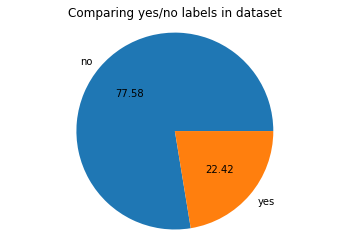

Date
Location
WindGustDir
WindDir9am
WindDir3pm


In [2]:
## all preprocessing in one go
df = pd.read_csv("weatherAUS.csv")
## replace yes and no with 1 and 0
df["RainTomorrow"].replace({"No":0,"Yes":1},inplace=True)
df["RainToday"].replace({"No":0,"Yes":1},inplace=True)

## handle imabalance in classes by over/undersampling
labels = ["no","yes"]
vals = [len(df[df["RainTomorrow"]==0]), len(df[df["RainTomorrow"]==1])]
plt.pie(vals,labels=labels,autopct="%.2f")
plt.title("Comparing yes/no labels in dataset")
plt.axis("equal")
plt.show()

no = df[df["RainTomorrow"]==0]
yes = df[df["RainTomorrow"]==1]

## resample with replacement (undersampling)
yes_oversampled = resample(yes,replace=True,n_samples=len(no))
adjusted_df = pd.concat([yes_oversampled,no])

def replace_with_mode(df,col):
    
    df[col] = df[col].replace(np.nan,df[col].mode()[0])
    
## replacing NaN values with mode value (since we have categorical values also)
oversampled = adjusted_df.sample(frac=1)
replace_with_mode(oversampled,"Date")
replace_with_mode(oversampled,"Location")
replace_with_mode(oversampled,"WindGustDir")
replace_with_mode(oversampled,"WindDir3pm")
replace_with_mode(oversampled,"WindDir9am")

## numerical to categorical using label encoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    print(col)
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

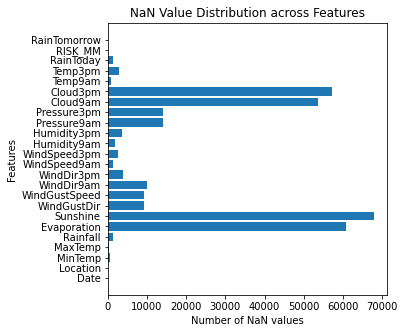

In [3]:
categorical_features = [column_name for column_name in df.columns]
x=df[categorical_features].isnull().sum()

fig = plt.figure(figsize = (5,5))
plt.barh(categorical_features,x)
plt.ylabel("Features")
plt.xlabel("Number of NaN values")
plt.title("NaN Value Distribution across Features")
plt.show()

In [6]:
## takes time to execute, doing imputation
import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
warnings.filterwarnings("ignore")

def removeOutliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Removing outliers from the dataset
    df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    return df

def getCopy(df):
    return df.copy(deep=True)
    
## imputation using MICE
miceImputed = getCopy(oversampled)
mice_imputer = IterativeImputer()

## estimates misisng values in each col using all other cols 
## in a round robin manner
miceImputed.iloc[:,:] = mice_imputer.fit_transform(oversampled)

# Detecting outliers with IQR
miceImputed = removeOutliers(miceImputed)

In [7]:
## choosing best K features

r_scaler = MinMaxScaler()
r_scaler.fit(miceImputed)
modified_data = pd.DataFrame(r_scaler.transform(miceImputed), index=miceImputed.index, columns=miceImputed.columns)

# selecting best features
x = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(k=11)
selector.fit(x, y)
print(x.columns[selector.get_support(indices=True)])

## doing train test split
features = miceImputed[x.columns[selector.get_support(indices=True)]]
features.drop('RISK_MM', axis=1, inplace=True)
target = miceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=0)
y_train = np.array(y_train)
y_test = np.array(y_test)
# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

Index(['Rainfall', 'Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday',
       'RISK_MM'],
      dtype='object')


<AxesSubplot:>

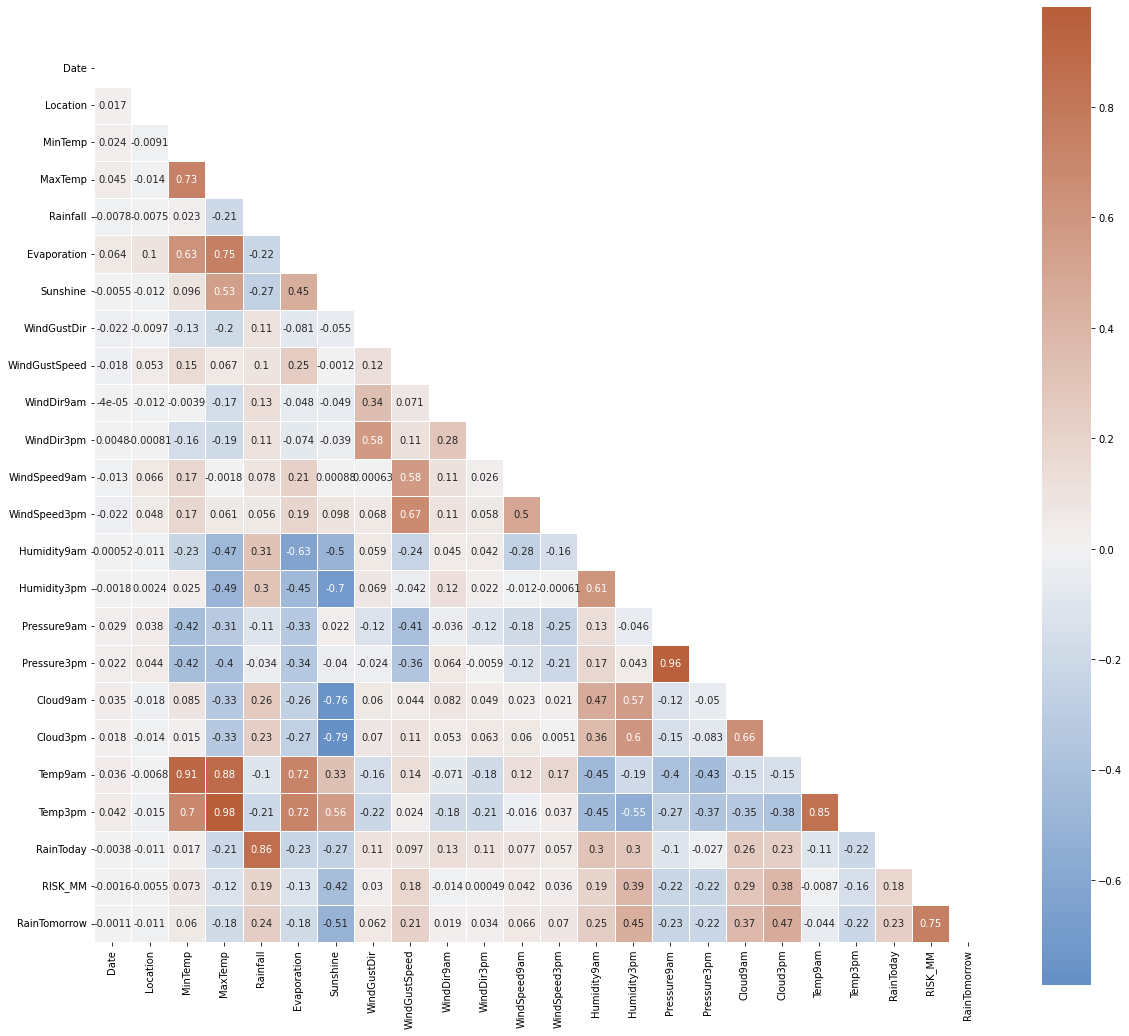

In [8]:
# Correlation Heatmap
corr = miceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

grid = {"C":[1e-2,1e-1,1,10,100],"penalty":["l1","l2"]}
clf = LogisticRegression()
model = GridSearchCV(clf,grid)
model.fit(x_train,y_train)
model.best_estimator_, model.cv_results_

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1)
clf.fit(x_train,y_train)
print(classification_report(clf.predict(x_train),y_train))
plot_roc_curve(clf,x_train,y_train,name="train")
print(classification_report(clf.predict(x_test),y_test))
plot_roc_curve(clf,x_test,y_test,name="test")
plt.show()

## SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier

grid = {"alpha":[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10],"loss":["hinge","log","modified_huber","squared_hinge","perceptron","squared_epsilon_insensitive"],"warm_start":[True,False]}
clf = SGDClassifier(n_jobs=-1)
model = GridSearchCV(clf,grid)
model.fit(x_train,y_train)
model.best_estimator_, model.cv_results_

In [ ]:
from sklearn.linear_model import SGDClassifier


clf = SGDClassifier(alpha=0.001, n_jobs=-1, loss="log", warm_start=True)
clf.fit(x_train,y_train)
print(classification_report(clf.predict(x_train),y_train))
plot_roc_curve(clf,x_train,y_train,name="train")
print(classification_report(clf.predict(x_test),y_test))
plot_roc_curve(clf,x_test,y_test,name="test")
plt.show()

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(x_train,y_train)
print(classification_report(clf.predict(x_train),y_train))
plot_roc_curve(clf,x_train,y_train,name="train")
print(classification_report(clf.predict(x_test),y_test))
plot_roc_curve(clf,x_test,y_test,name="test")
plt.show()

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

grid = {"criterion":["gini","entropy"],"max_features":["auto","log2"],"max_depth":[2,4,8,16,32,64]}
clf = DecisionTreeClassifier()
model = GridSearchCV(clf,grid)
model.fit(x_train,y_train)
model.best_estimator_, model.cv_results_

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=8)
clf.fit(x_train,y_train)
print(classification_report(clf.predict(x_train),y_train))
plot_roc_curve(clf,x_train,y_train,name="train")
print(classification_report(clf.predict(x_test),y_test))
plot_roc_curve(clf,x_test,y_test,name="test")
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
grid = {"n_estimators":[50,100,200]}
clf = RandomForestClassifier(max_depth=8)
model = GridSearchCV(clf,grid)
model.fit(x_train,y_train)

In [ ]:
model.best_estimator_, model.cv_results_

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50, max_depth=8)
clf.fit(x_train,y_train)
clf.score(x_test,y_test), clf.score(x_train,y_train)

In [ ]:
print(classification_report(clf.predict(x_train),y_train))
plot_roc_curve(clf,x_train,y_train,name="train")
print(classification_report(clf.predict(x_test),y_test))
plot_roc_curve(clf,x_test,y_test,name="test")
plt.show()

In [ ]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.fit(x_train,y_train)
print(classification_report(clf.predict(x_train),y_train))
plot_roc_curve(clf,x_train,y_train,name="train")
print(classification_report(clf.predict(x_test),y_test))
plot_roc_curve(clf,x_test,y_test,name="test")
plt.show()